## Mengambil dataset dari google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

# Fungsi untuk ekstraksi file ZIP
def extract_zip(zip_file_path, extract_dir):
    os.makedirs(extract_dir, exist_ok=True)
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"File dari {zip_file_path} telah diekstrak ke {extract_dir}")

# Ekstraksi dataset
extract_zip('/content/drive/MyDrive/dataset.zip', '/content/dataset/')

File dari /content/drive/MyDrive/Adik Drive/dataset.zip telah diekstrak ke /content/dataset/


In [3]:

# List file yang telah diekstrak
print("File yang telah diekstrak dari dataset.zip:")
print(os.listdir('/content/dataset/'))

File yang telah diekstrak dari dataset.zip:
['test', 'train']


## Importing the libraries

In [4]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
tf.__version__

'2.15.0'

# Part 1 - Data Preprocessing

In [7]:
# Augmentasi data untuk generator pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Augmentasi data untuk generator validasi (hanya rescaling)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Generator pelatihan
training_set = train_datagen.flow_from_directory(
        '/content/dataset/train',
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical')

# Generator validasi
validation_set = validation_datagen.flow_from_directory(
        '/content/dataset/test',
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical')

Found 2339 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


# Part 2 - Building the CNN

## Initialising the CNN

In [8]:
cnn = tf.keras.models.Sequential()

## Step 1 - Convolution

In [9]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[128, 128, 3]))

## Step 2 - Pooling

In [10]:
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

## Adding more convolutional and pooling layers

In [11]:
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

## Step 3 - Flattening

In [12]:
cnn.add(tf.keras.layers.Flatten())

## Step 4 - Full Connection

In [13]:
cnn.add(tf.keras.layers.Dense(units=256, activation='relu'))
cnn.add(tf.keras.layers.Dropout(0.5))

cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(tf.keras.layers.Dropout(0.5))

## Step 5 - Output Layer

In [14]:
cnn.add(tf.keras.layers.Dense(units=10, activation='softmax'))

# Part 3 - Training the CNN

## Compiling the CNN

In [15]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Reduce Learning Rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Training the CNN on the Training set and evaluating it on the Test set

Epoch 50/50
74/74 [==============================] - 12s 163ms/step - loss: 0.4326 - accuracy: 0.8478 - val_loss: 0.7329 - val_accuracy: 0.7800
<keras.src.callbacks.History at 0x78c0b5103280>

In [17]:
history = cnn.fit(x=training_set, validation_data=validation_set, epochs=100, callbacks=[early_stopping, reduce_lr])

Epoch 1/100
74/74 [==============================] - 20s 177ms/step - loss: 2.2972 - accuracy: 0.0915 - val_loss: 2.2181 - val_accuracy: 0.1400 - lr: 0.0010
Epoch 2/100
74/74 [==============================] - 11s 147ms/step - loss: 2.0760 - accuracy: 0.1937 - val_loss: 2.5398 - val_accuracy: 0.1200 - lr: 0.0010
Epoch 3/100
74/74 [==============================] - 12s 159ms/step - loss: 1.9656 - accuracy: 0.2112 - val_loss: 2.2856 - val_accuracy: 0.1600 - lr: 0.0010
Epoch 4/100
74/74 [==============================] - 12s 159ms/step - loss: 1.8826 - accuracy: 0.2505 - val_loss: 2.0819 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 5/100
74/74 [==============================] - 11s 151ms/step - loss: 1.8460 - accuracy: 0.2706 - val_loss: 2.3303 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 6/100
74/74 [==============================] - 12s 159ms/step - loss: 1.7340 - accuracy: 0.3001 - val_loss: 1.9038 - val_accuracy: 0.2400 - lr: 0.0010
Epoch 7/100
74/74 [==============================] - 12s 1

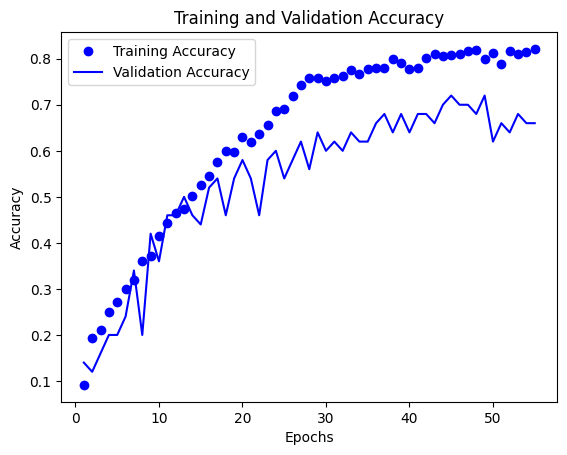

In [18]:
import matplotlib.pyplot as plt

# Ambil data akurasi dari riwayat pelatihan
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Ambil jumlah epochs
epochs = range(1, len(train_accuracy) + 1)

# Buat plot akurasi pelatihan dan validasi
plt.plot(epochs, train_accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Tampilkan plot
plt.show()

# Part 4 - Making a single prediction with image upload

In [19]:
import numpy as np
from keras.preprocessing import image
from google.colab import files
from IPython.display import Image

Saving 5.jpg to 5 (3).jpg
1/1 [==============================] - 0s 35ms/step


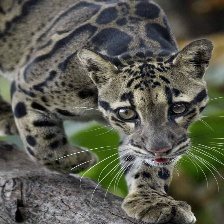

Predicted class: OCELOT


In [40]:
# Upload image
uploaded = files.upload()


for filename in uploaded.keys():
    # Load and preprocess the image
    test_image = image.load_img(filename, target_size=(128, 128))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)

    # Predict the class
    result = cnn.predict(test_image)
    class_indices = training_set.class_indices
    class_indices = {v: k for k, v in class_indices.items()}
    prediction = class_indices[np.argmax(result)]

    # Display the image and prediction
    display(Image(filename=filename))
    print(f"Predicted class: {prediction}")

In [ ]:
# Simpan model ke dalam format HDF5 secara lokal
cnn.save('cnn_model.h5')
print("Model telah disimpan sebagai cnn_model.h5")

Model telah disimpan sebagai cnn_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
